
Представляем реализацию статьи A Neural Algorithm of Artistic Style

Для запуска понадобится:

Предварительно обученный pth-файл vgg19
(https://drive.google.com/file/d/1rotfSFB2Uj6nxCIEubgFy-mCbYNSxavO/view?usp=sharing)

Обученная модель([отсюда](https://github.com/MAlberts99/PyTorch-AdaIN-StyleTransfer))
https://drive.google.com/file/d/1-96gmMVd1wYbP0WNM7KMF2gCIqtQ6ZtA/view

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision

from google.colab import drive
from PIL import Image
import os
import sys

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io, img_as_float

In [ ]:
!mkdir media
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/abstraktsiya.jpg -P media &> /dev/null
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/moskva.jpg -P media &> /dev/null
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/abstraktnye-cveta.jpg -P media &> /dev/null
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/mount.jpg -P media &> /dev/null
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/rain_princess.jpg  -P media &> /dev/null

!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/marylin-monroe-pop-art-ahmad-nusyirwan.jpg -P media &> /dev/null
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/1000.png  -P media &> /dev/null
!wget https://raw.githubusercontent.com/sw-shar/StyleTransfer/main/Image/art-narisovannaya-devushka-vzglyad-blondinka.jpg -P media &> /dev/null

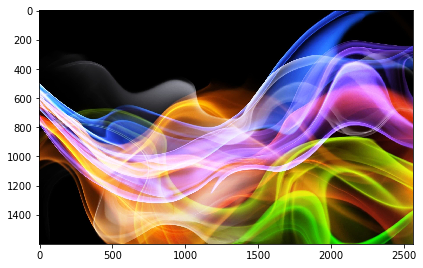

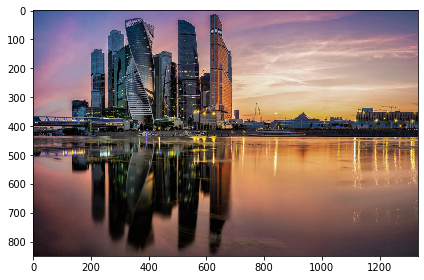

In [ ]:
# Загрузим картинки и приведем их к размеру 224x224

style_img = img_as_float(io.imread('/content/media/abstraktsiya.jpg'))
#style_img = transform.resize(style_img, [224, 224])
content_img = img_as_float(io.imread('/content/media/moskva.jpg'))
#content_img = transform.resize(content_img, [224, 224])

io.imshow(style_img)
io.show()
io.imshow(content_img)
io.show()

В статье представлен новый алгоритм передачи стиля, который использует фиксированный предварительно обученный vgg19 (до ReLU 4.1) для кодирования изображения стиля и изображения содержимого. Затем стиль изображения стиля переносится на изображение содержимого. Новый подход, описанный в этой статье, использует слой AdaIN для передачи стиля. Этот слой сначала нормализует изображение содержимого к среднему значению единицы и стандартному отклонению. После этого изображение содержимого масштабируется таким образом, чтобы его среднее значение и стандартное отклонение равнялись среднему значению и стандартному отклонению изображения стиля. Затем изображение декодируется с помощью декодера

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.padding = nn.ReflectionPad2d(padding=1) # Using reflection padding as described in vgg19
    self.UpSample = nn.Upsample(scale_factor=2, mode="nearest")

    self.conv4_1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0)

    self.conv3_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0)

    self.conv2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0)

    self.conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=0)


  def forward(self, x):
    out = self.UpSample(F.relu(self.conv4_1(self.padding(x))))

    out = F.relu(self.conv3_1(self.padding(out)))
    out = F.relu(self.conv3_2(self.padding(out)))
    out = F.relu(self.conv3_3(self.padding(out)))
    out = self.UpSample(F.relu(self.conv3_4(self.padding(out))))

    out = F.relu(self.conv2_1(self.padding(out)))
    out = self.UpSample(F.relu(self.conv2_2(self.padding(out))))

    out = F.relu(self.conv1_1(self.padding(out)))
    out = self.conv1_2(self.padding(out))
    return out
# Последовательность vgg19, которая используется до Relu 4.1. Отметим, что
# первый слой представляет собой свертку 3,3, отличную от стандартной vgg19

class Encoder(nn.Module):
    def __init__(self, state_dict, device):
        super().__init__()
        self.vgg19 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True), # First layer from which Style Loss is calculated
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True), # Second layer from which Style Loss is calculated
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            nn.ReflectionPad2d(padding=1), # Third layer from which Style Loss is calculated
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True), # This is Relu 4.1 The output layer of the encoder.
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(padding=1),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.ReLU(inplace=True)
            ).to(device)

        self.vgg19.load_state_dict(state_dict)

        encoder_children = list(self.vgg19.children())
        self.EncoderList = nn.ModuleList([nn.Sequential(*encoder_children[:4]), # Up to Relu 1.1
                                          nn.Sequential(*encoder_children[4:11]), # Up to Relu 2.1
                                          nn.Sequential(*encoder_children[11:18]), # Up to Relu 3.1
                                          nn.Sequential(*encoder_children[18:31]), # Up to Relu 4.1, also the
                                          ])                                       # input for the decoder

    def forward(self, x, intermediates=False): # if training use intermediates = True, to get the output of
        states = []                            # all the encoder layers to calculate the style loss
        for i in range(len(self.EncoderList)):
            x = self.EncoderList[i](x)

            if intermediates:       # All intermediate states get saved in states
                states.append(x)
        if intermediates:
            return states
        return x

class StyleTransferNetwork(nn.Module):
  def __init__(self,
               device, # "cpu" for cpu, "cuda" for gpu
               enc_state_dict, #Состояние предварительно обученного vgg19
               learning_rate=1e-4,
               learning_rate_decay=5e-5, # Параметр затухания для скорости обучения
               gamma=6, # Управляет важностью StyleLoss и ContentLoss, Loss = gamma*StyleLoss + ContentLoss
               train=True, # Обучается сеть или нет
               load_fromstate=False, # Загрузить с контрольной точки?
               load_path=None # Путь для загрузки контрольной точки
              
               ):
    super().__init__()

    assert device in ["cpu", "cuda"]
    if load_fromstate and not os.path.isfile(load_path):
      raise ValueError("Checkpoint file not found")


    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.train = train
    self.gamma = gamma

    self.encoder = Encoder(enc_state_dict, device) # В качестве кодировщика используется предварительно обученный vgg19.
    self.decoder = Decoder().to(device)

    self.optimiser = optim.Adam(self.decoder.parameters(), lr=self.learning_rate)
    self.iters = 0

    if load_fromstate:
      state = torch.load(load_path)
      self.decoder.load_state_dict(state["Decoder"])
      self.optimiser.load_state_dict(state["Optimiser"])
      self.iters = state["iters"]


  def set_train(self, boolean): # Изменить состояние сети
    assert type(boolean) == bool
    self.train = boolean

  def adjust_learning_rate(self, optimiser, iters): # Простое снижение скорости обучения
    lr = learning_rate / (1.0 + learning_rate_decay * iters)
    for param_group in optimiser.param_groups:
        param_group['lr'] = lr

  def forward(self, style, content, alpha=1.0): # Альфа может использоваться во время тестирования для контроля важности переданного стиля.

    # Encode style and content
    layers_style = self.encoder(style, self.train) # if train: возвращает все состояния
    layer_content = self.encoder(content, False) # для контента важен только последний слой

    # Transfer Style
    if self.train:
      style_applied = AdaIn(layer_content, layers_style[-1]) # Последний слой - это слой «стиль».
    else:
      style_applied = alpha*AdaIn(layer_content, layers_style) + (1-alpha)*layer_content # Альфа контролирует величину стиля

    # Scale up
    style_applied_upscaled = self.decoder(style_applied)
    if not self.train:
      return style_applied_upscaled # Когда не тренируется, возвращайте преобразованное изображение

    # Вычислить потери
    layers_style_applied = self.encoder(style_applied_upscaled, self.train)

    content_loss = Content_loss(layers_style_applied[-1], layer_content)
    style_loss = Style_loss(layers_style_applied, layers_style)

    loss_comb = content_loss + self.gamma*style_loss

    return loss_comb, content_loss, style_loss

# Декодер представляет собой перевернутый vgg19 до ReLU 4.1. Обратите внимание, что последний слой не активирован.

In [ ]:
import torch
import torch.nn.functional as F

# Вычисляет среднее и стандартное значение по каналам
def calc_mean_std(input, eps=1e-5):
  batch_size, channels = input.shape[:2]

  reshaped = input.view(batch_size, channels, -1) # Изменить форму канала
  mean = torch.mean(reshaped, dim = 2).view(batch_size, channels, 1, 1) # Вычислить среднее значение и изменить форму
  std = torch.sqrt(torch.var(reshaped, dim=2)+eps).view(batch_size, channels, 1, 1) # Вычислите дисперсию, добавьте эпсилон (избегайте деления на 0),
                                                                                    # рассчитать std и изменить форму
  return mean, std

def AdaIn(content, style):
  assert content.shape[:2] == style.shape[:2] #Только первые два затемнения, так что возможны разные размеры изображения
  batch_size, n_channels = content.shape[:2]
  mean_content, std_content = calc_mean_std(content)
  mean_style, std_style = calc_mean_std(style)

  output = std_style*((content - mean_content) / (std_content)) + mean_style # Нормализуйте, затем измените среднее значение и станд.
  return output

def Content_loss(input, target): # Потеря контента — это простая потеря MSE
  loss = F.mse_loss(input, target)
  return loss

def Style_loss(input, target):
  mean_loss, std_loss = 0, 0

  for input_layer, target_layer in zip(input, target): 
    mean_input_layer, std_input_layer = calc_mean_std(input_layer)
    mean_target_layer, std_target_layer = calc_mean_std(target_layer)

    mean_loss += F.mse_loss(mean_input_layer, mean_target_layer)
    std_loss += F.mse_loss(std_input_layer, std_target_layer)

  return mean_loss+std_loss

In [ ]:
# Укажите путь путь к каталогу
path = "/content/"
sys.path.append(path)

In [ ]:
path_check = os.path.join(path, "StyleTransfer Checkpoint Iter_ 120000.tar")
state_vgg = torch.load(os.path.join(path, "vgg_normalised.pth"), map_location=torch.device("cpu"))

In [ ]:
img_dir = "Images"

device = ("cuda" if torch.cuda.is_available() else "cpu")


network = StyleTransferNetwork(device, state_vgg, train=False, load_fromstate=True, load_path=path_check)

In [ ]:
transform = transforms.Compose([transforms.Resize(512),
                               #transforms.CenterCrop(256),
                               transforms.ToTensor()])

toPIL = transforms.ToPILImage(mode="RGB")

In [ ]:
def paint(way_style,way_content,alpha):
  # Загрузить изображение, преобразовать в RGB, преобразовать, добавить размер 0 и переместить на устройство
  style = transform(Image.open(way_style).convert("RGB")).unsqueeze(0).to(device)
  content = transform(Image.open(way_content).convert("RGB")).unsqueeze(0).to(device)

  style_img = img_as_float(io.imread(way_style))
  content_img = img_as_float(io.imread(way_content))

  out = network(style, content, alpha).cpu()
  # convert to grid/image
  out = torchvision.utils.make_grid(out.clamp(min=-1, max=1), nrow=3, scale_each=True, normalize=True)
  # Make Pil
  img = toPIL(out)

  images = [style_img, content_img, img]
  titles = ['Style', 'Content', 'Adaptive']

  import matplotlib.pyplot as plt
  fig = plt.figure(figsize=(15, 20))
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])

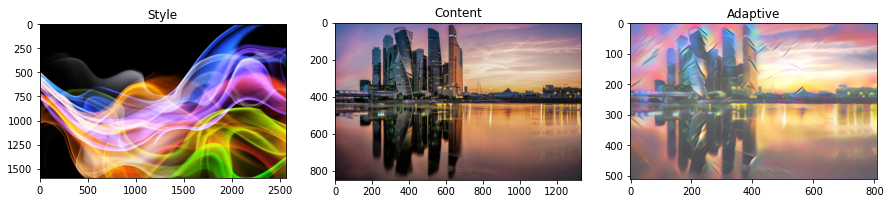

In [ ]:
way_style = '/content/media/abstraktsiya.jpg'
way_content = "/content/media/moskva.jpg"
alpha = 1


paint(way_style,way_content,alpha)

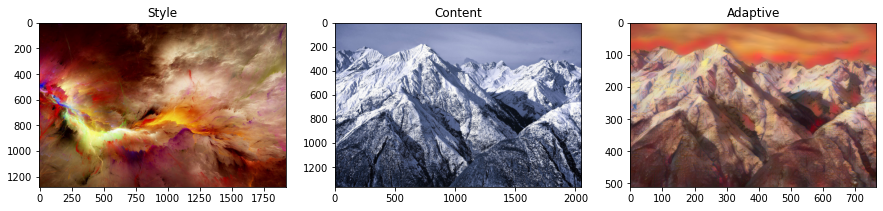

In [ ]:
way_style = '/content/media/abstraktnye-cveta.jpg'
way_content = "/content/media/mount.jpg"
alpha = 0.9


paint(way_style,way_content,alpha)

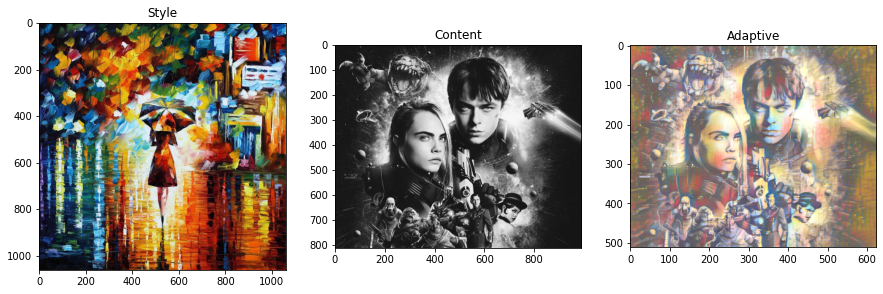

In [ ]:
way_style = '/content/media/rain_princess.jpg'
way_content = "/content/media/1000.png"
alpha = 1


paint(way_style,way_content,alpha)

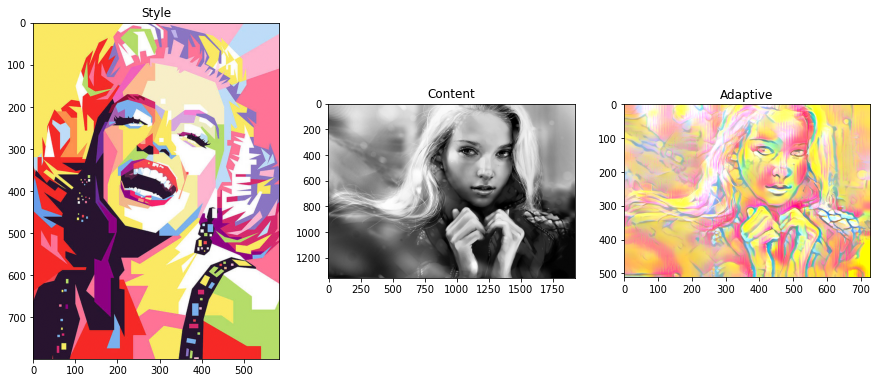

In [ ]:
way_style = '/content/media/marylin-monroe-pop-art-ahmad-nusyirwan.jpg'
way_content = '/content/media/art-narisovannaya-devushka-vzglyad-blondinka.jpg'
alpha = 3


paint(way_style,way_content,alpha)